In [1]:
pip install pandas scikit-learn numpy rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 53.7 MB/s eta 0:00:00


In [9]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs

In [3]:
#read dataframe
df = pd.read_csv("glp_full.csv")

In [5]:
#extract smiles and pChEMBL values
smiles =df['Smiles']
pchembl_value=df['pChEMBL Value']

In [10]:
#convert smiles to molecular fingerprints
from rdkit.Chem import rdFingerprintGenerator

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048)  # Handle invalid SMILES
    # Use MorganGenerator
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)
    fp = generator.GetFingerprint(mol)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply the function to the SMILES column
X = np.array([smiles_to_fingerprint(sm) for sm in smiles])

In [12]:
#define target
y = df['pChEMBL Value']

In [14]:
#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
#feature scaling (SVR is sensitive to the scale of input features)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

#fit to training data and transform test and training data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

#reshape y so it fits the scaler
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [17]:
#train the model
svr = SVR(kernel ='poly', C=1.0, epsilon=0.1)

#fit the model to the training data
svr.fit(X_train_scaled, y_train_scaled)


SVR(kernel='poly')

In [18]:
#make predictions
y_pred_scaled = svr.predict(X_test_scaled)

#reshape y_pred_scaled to a 2D array
y_pred_scaled = y_pred_scaled.reshape(-1, 1)

#transform back to origional scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)

In [19]:
#evaluation of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean Squared Error: 1.4837176061282498
R2 Score: 0.502720513542303


In [ ]:
#hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train_scaled)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


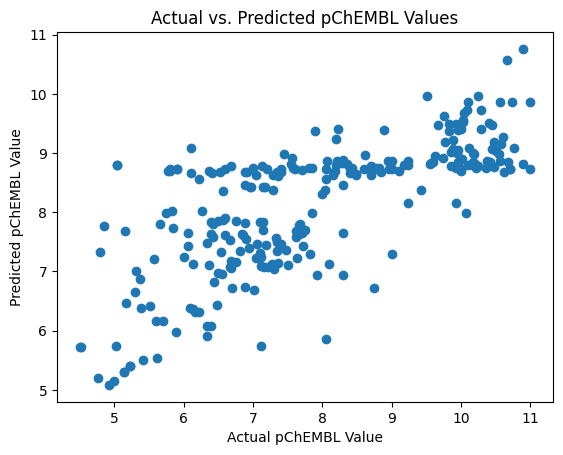

In [21]:
#visualisation of results
import matplotlib.pyplot as plt

#scatter plot of predicted vs actual pChEMBL Values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual pChEMBL Value')
plt.ylabel('Predicted pChEMBL Value')
plt.title('Actual vs. Predicted pChEMBL Values')
plt.show()

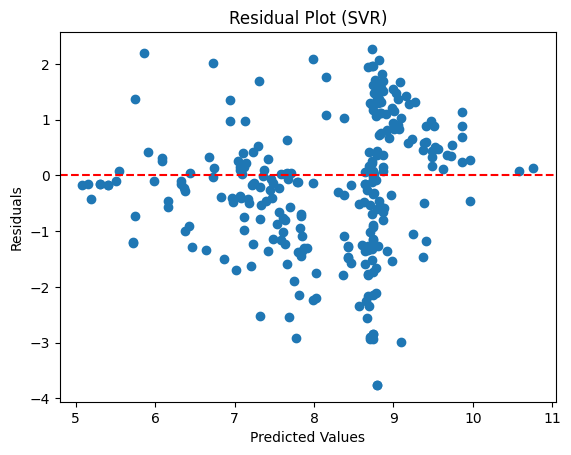

In [39]:
#Residual Plot

# Convert y_pred to a 1D array
y_pred_1d = y_pred.flatten()
y_test_1d = y_test.values.flatten() # Extract values from the Series and flatten

residuals = y_test_1d - y_pred_1d # Subtract 1D arrays
plt.scatter(y_pred_1d, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (SVR)')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at zero
plt.show()